In [ ]:
%pip install numpy
%pip install matplotlib
%pip install opencv-python
%pip install seaborn

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import pdr
import os

In [26]:
dimensao = 50

In [27]:
pasta_raiz = "RecFac"
caminho_pessoas = [x[0] for x in os.walk(pasta_raiz)]
caminho_pessoas.pop(0)

'RecFac'

In [28]:
C = 20  # Total de classes
X = np.empty((dimensao * dimensao, 0))  # Matriz de dados (p x N)
Y = np.empty((C, 0)) # Matriz rotulos one-hot encode

In [29]:
for i, pessoa in enumerate(caminho_pessoas):
    imagens_pessoa = os.listdir(pessoa)
    for imagem in imagens_pessoa:
        caminho_imagem = os.path.join(pessoa, imagem)
        imagem_original = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
        imagem_redimensionada = cv2.resize(imagem_original, (dimensao, dimensao))

        # Vetorizando a imagem
        x = imagem_redimensionada.flatten()

        # Empilhando amostra na matriz X
        X = np.concatenate((X, x.reshape(dimensao * dimensao, 1)), axis=1)

        # One-hot encoding para a matriz Y
        y = np.zeros((C, 1))
        y[i, 0] = 1  # Define o valor 1 na posição da classe correspondente
        Y = np.concatenate((Y, y), axis=1)

In [30]:
X = X / 255.0

In [51]:
class Perceptron(object):
    def __init__(self, eta = 0.01, n_iter = 150):
        self.eta = eta
        self.n_iter = n_iter
        self.errors_ = []

    def train_perceptron(self, X, Y):
        n_features, n_samples = X.shape
        n_classes = Y.shape[0]
        W = np.random.rand(n_features, n_classes)  # Inicializa os pesos aleatoriamente
        self.errors_ = []
        for epoch in range(max_epochs):
            epoch_error = 0
            for i in range(n_samples):
                xi = X[:, i].reshape(-1, 1)
                yi = Y[:, i].reshape(-1, 1)
                output = np.dot(W.T, xi)
                prediction = (output >= 0).astype(int)  # Função degrau
                error = yi - prediction
                epoch_error += np.sum(np.abs(error))
                W += eta * np.dot(xi, (yi - prediction).T)
            self.errors_.append(epoch_error)
        self.W_ = W
        return W

    def predict(self, X):
        output = np.dot(self.W_.T, X)
        return (output >= 0).astype(int)

In [32]:
class Adaline:
    def __init__(self, eta=0.001, n_iter=150):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, Y):
        n_features, n_samples = X.shape
        n_classes = Y.shape[0]
        
        # Inicialização dos pesos
        self.W_ = np.random.uniform(-0.01, 0.01, (n_features, n_classes))
        self.bias_ = np.zeros((1, n_classes))
        self.cost_ = []

        for _ in range(self.n_iter):
            # Cálculo da saída linear
            output = self.net_input(X)
            # Erro
            errors = Y.T - output
            # Atualização dos pesos
            self.W_ += self.eta * np.dot(X, errors)
            self.bias_ += self.eta * errors.sum(axis=0, keepdims=True)
            # Função de custo (erro quadrático médio)
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        
        return self

    def net_input(self, X):
        return np.dot(X.T, self.W_) + self.bias_

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        output = self.activation(X)
        return np.argmax(output, axis=1)

In [33]:
class MLP:
    def __init__(self, input_size, hidden_layers, output_size, activation="sigmoid", learning_rate=0.01):
        self.layers = []
        self.biases = []
        self.learning_rate = learning_rate
        self.activation_func = self.sigmoid if activation == "sigmoid" else self.tanh
        self.activation_deriv = self.sigmoid_derivative if activation == "sigmoid" else self.tanh_derivative

        # Inicializar pesos e bias para cada camada
        layer_sizes = [input_size] + hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.layers.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) / np.sqrt(layer_sizes[i]))
            self.biases.append(np.zeros((1, layer_sizes[i + 1])))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - x**2

    def forward(self, X):
        activations = [X]
        for w, b in zip(self.layers, self.biases):
            X = self.activation_func(np.dot(X, w) + b)
            activations.append(X)
        return activations

    def backward(self, activations, y):
        deltas = []
        output_error = activations[-1] - y
        deltas.append(output_error * self.activation_deriv(activations[-1]))

        for i in range(len(self.layers) - 2, -1, -1):
            error = np.dot(deltas[0], self.layers[i + 1].T)
            deltas.insert(0, error * self.activation_deriv(activations[i + 1]))

        for i in range(len(self.layers)):
            self.layers[i] -= self.learning_rate * np.dot(activations[i].T, deltas[i])
            self.biases[i] -= self.learning_rate * np.sum(deltas[i], axis=0, keepdims=True)

    def train(self, X, y, epochs=1000, tolerance=1e-4):
        self.loss_history = []
        for epoch in range(epochs):
            activations = self.forward(X)
            self.backward(activations, y)

            loss = np.mean((activations[-1] - y) ** 2)
            self.loss_history.append(loss)

            if loss < tolerance:
                break

    def predict(self, X):
        output = self.forward(X)[-1]
        return np.argmax(output, axis=1)

In [34]:
def print_results(name, results):
    print(f'\n{name}')
    metrics = ["accuracy", "sensitivity", "specificity"]
    labels = ["Acurácia", "Sensibilidade", "Especificidade"]

    for metric, label in zip(metrics, labels):
        mean_value = np.mean(results[metric])
        std_dev = np.std(results[metric])
        max_value = np.max(results[metric])
        min_value = np.min(results[metric])

        print(f'''\
Média de {label}: {mean_value:.4f} 
Desvio-padrão: {std_dev:.4f} 
Máximo: {max_value:.4f} 
Mínimo: {min_value:.4f}'''
        )

In [35]:
R = 3
n_samples = X.shape[1]
results = {"Perceptron": {"accuracy": [], "sensitivity": [], "specificity": []},
            "Adaline": {"accuracy": [], "sensitivity": [], "specificity": []},
            "MLP": {"accuracy": [], "sensitivity": [], "specificity": []}}

y_test_all_perceptron = []  
y_pred_all_perceptron = []  
X_train_ = []
y_train_ = []
X_trainMLP_ = []
y_trainMLP_ = []

y_test_all_adaline = []  
y_pred_all_adaline = []  

y_test_all_mlp = []  
y_pred_all_mlp = [] 


eta = 0.01
max_epochs = 150 # Perceptron & Adaline

input_size = dimensao * dimensao
hidden_layers = [10, 10, 10]
output_size = C
learning_rate = 0.00001
max_epochsmlp = 5000
tolerance = 1e-4


In [36]:
for r in range(R):
    print(f"Rodada: {r+1}", end='\r')
    # Divisão em treino e teste
    indices = np.random.permutation(n_samples)
    split = int(0.8 * n_samples)
    train_idx, test_idx = indices[:split], indices[split:]

    X_train, Y_train = X[:, train_idx], Y[:, train_idx]
    X_test, Y_test = X[:, test_idx], Y[:, test_idx]
    
    X_train_.append(X_train)
    y_train_.append(Y_train)
    
    # Treinar o MLP
    X_trainMLP = X_train.T
    Y_trainMLP = Y_train.T
    X_trainMLP_.append(X_trainMLP)
    y_trainMLP_.append(Y_trainMLP)
    mlp = MLP(input_size, hidden_layers, output_size, activation="tanh", learning_rate=learning_rate)
    mlp.train(X_trainMLP, Y_trainMLP, epochs=max_epochsmlp, tolerance=tolerance)

    # Realizar a previsão
    X_testMLP = X_test.T
    y_pred_mlp = mlp.predict(X_testMLP)
    y_pred_all_mlp.append(y_pred_mlp)

    # Perceptron
    W_perceptron = Perceptron(eta, max_epochs)
    W_perceptron.train_perceptron(X_train, Y_train)
    Y_pred_perceptron = W_perceptron.predict(X_test)
    X_train_.append(X_train)
    y_train_.append(Y_train)

    y_test_all_perceptron.append(Y_test)
    y_pred_all_perceptron.append(Y_pred_perceptron)

    y_trueMLP = np.argmax(Y_test, axis=0)

    accuracy = np.mean(y_pred_mlp == y_trueMLP, axis=0)
    results["MLP"]["accuracy"].append(accuracy)

    accuracy = np.mean(np.all(Y_pred_perceptron == Y_test, axis=0))
    results["Perceptron"]["accuracy"].append(accuracy)
   
    TP = np.sum((Y_test == 1) & (Y_pred_perceptron == 1))
    TN = np.sum((Y_test == 0) & (Y_pred_perceptron == 0))
    FP = np.sum((Y_test == 0) & (Y_pred_perceptron == 1))
    FN = np.sum((Y_test == 1) & (Y_pred_perceptron == 0))

    sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
    specificity = TN / (TN + FP) if TN + FP > 0 else 0
    results["Perceptron"]["sensitivity"].append(sensitivity)
    results["Perceptron"]["specificity"].append(specificity)  

    TP = np.sum((Y_test == 1) & (y_pred_mlp == 1))
    TN = np.sum((Y_test == 0) & (y_pred_mlp == 0))
    FP = np.sum((Y_test == 0) & (y_pred_mlp == 1))
    FN = np.sum((Y_test == 1) & (y_pred_mlp == 0))

    sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
    specificity = TN / (TN + FP) if TN + FP > 0 else 0
    results["MLP"]["sensitivity"].append(sensitivity)
    results["MLP"]["specificity"].append(specificity)

    # Adaline
    adaline = Adaline(eta=0.00001, n_iter=150)
    adaline.fit(X, Y) 
    Y_pred_adaline = adaline.predict(X_test)  

    # Obtenha os índices das classes verdadeiras a partir de Y_test
    Y_true = np.argmax(Y_test, axis=0)
    
    # Compare com as previsões para calcular a acurácia
    accuracy = np.mean(Y_pred_adaline == Y_true)
    results["Adaline"]["accuracy"].append(accuracy)

    y_test_all_adaline.append(Y_test)
    y_pred_all_adaline.append(Y_pred_adaline)

    TP = np.sum((Y_test == 1) & (Y_pred_adaline == 1))
    TN = np.sum((Y_test == 0) & (Y_pred_adaline == 0))
    FP = np.sum((Y_test == 0) & (Y_pred_adaline == 1))
    FN = np.sum((Y_test == 1) & (Y_pred_adaline == 0))

    sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
    specificity = TN / (TN + FP) if TN + FP > 0 else 0
    results["Adaline"]["sensitivity"].append(sensitivity)
    results["Adaline"]["specificity"].append(specificity)


Função para construir e plotar a matriz de confusão

In [37]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = np.zeros((C, C), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[int(true), int(pred)] += 1  # Garantir que os valores sejam inteiros

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    title = f'Confusion Matrix for {model_name}'
    plt.title(title)
    # plt.savefig(path_to_save + ''.join(title.split(' ')) + '2')
    plt.show()

Função para plotar as curvas de aprendizado

In [38]:
def plot_learning_curve(results, model_name):
    accuracy = results["accuracy"]
    epochs = np.arange(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, label=f'{model_name} Accuracy', color='darkgreen')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    title = f'Learning Curve for {model_name}'
    plt.title(title)
    plt.legend()
    # plt.savefig(path_to_save + ''.join(title.split(' ')) + '2')
    plt.show()

Impressão dos resultados

In [39]:
print_results("Perceptron", results["Perceptron"])
print_results("Adaline", results["Adaline"])
print_results("MLP", results["MLP"])

class_names = sorted(os.listdir(pasta_raiz))


Perceptron
Média de Acurácia: 0.8646 
Desvio-padrão: 0.0390 
Máximo: 0.9062 
Mínimo: 0.8125
Média de Sensibilidade: 0.8906 
Desvio-padrão: 0.0278 
Máximo: 0.9141 
Mínimo: 0.8516
Média de Especificidade: 0.9934 
Desvio-padrão: 0.0045 
Máximo: 0.9979 
Mínimo: 0.9873

Adaline
Média de Acurácia: 0.9714 
Desvio-padrão: 0.0161 
Máximo: 0.9922 
Mínimo: 0.9531
Média de Sensibilidade: 0.4786 
Desvio-padrão: 0.1470 
Máximo: 0.6667 
Mínimo: 0.3077
Média de Especificidade: 0.5214 
Desvio-padrão: 0.1470 
Máximo: 0.6923 
Mínimo: 0.3333

MLP
Média de Acurácia: 0.9193 
Desvio-padrão: 0.0385 
Máximo: 0.9688 
Mínimo: 0.8750
Média de Sensibilidade: 0.4597 
Desvio-padrão: 0.2307 
Máximo: 0.7857 
Mínimo: 0.2857
Média de Especificidade: 0.5403 
Desvio-padrão: 0.2307 
Máximo: 0.7143 
Mínimo: 0.2143


Selecionando as rodadas com maior e menor acurácia

In [40]:
acc = results["Perceptron"]["accuracy"]
max_accuracy_idx_perceptron = np.argmax(acc)
min_accuracy_idx_perceptron = np.argmin(acc)

acc = results["Adaline"]["accuracy"]
max_accuracy_idx_adaline = np.argmax(acc)
min_accuracy_idx_adaline = np.argmin(acc)

acc = results["MLP"]["accuracy"]
max_accuracy_idx_mlp = np.argmax(acc)
min_accuracy_idx_mlp = np.argmin(acc)

Para o Perceptron

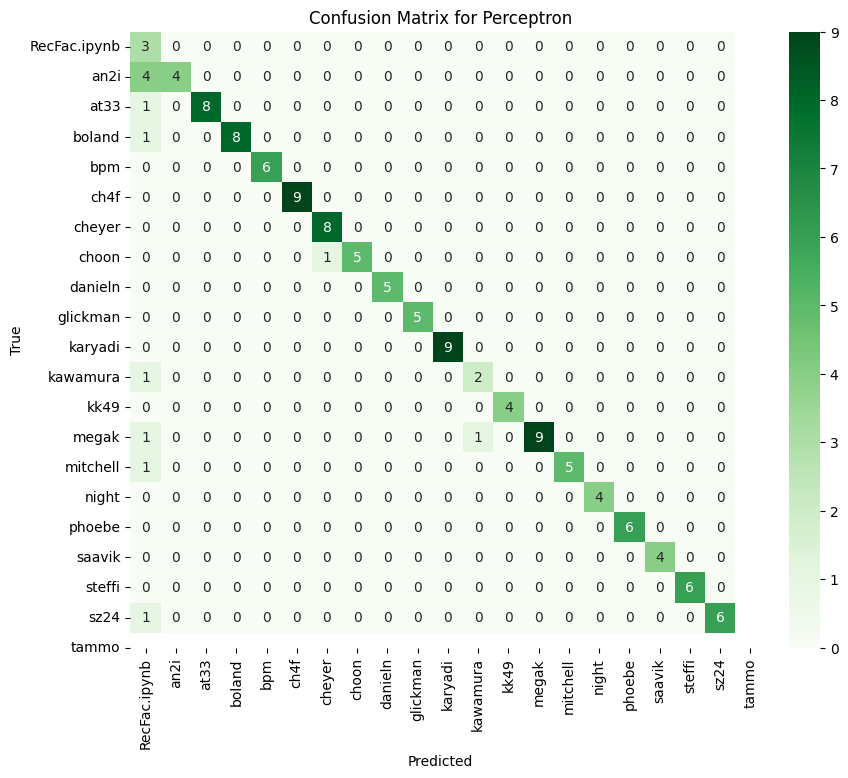

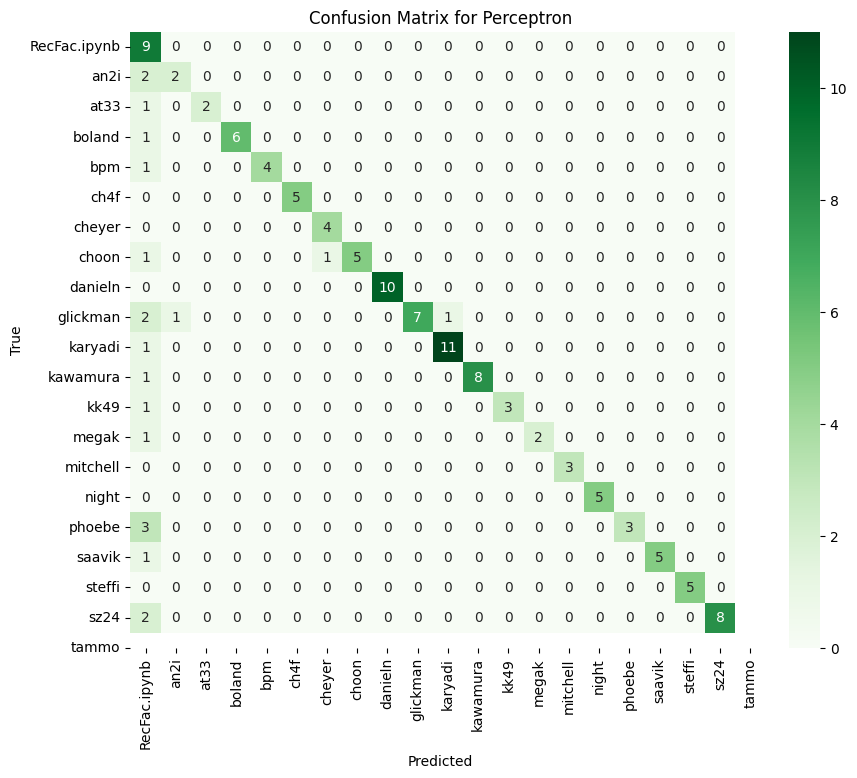

In [41]:
y_test_best_perceptron = y_test_all_perceptron[max_accuracy_idx_perceptron]
y_pred_best_perceptron = y_pred_all_perceptron[max_accuracy_idx_perceptron]
Y_best_true = np.argmax(y_test_best_perceptron, axis=0)
Y_best_pred_perceptron = np.argmax(y_pred_best_perceptron, axis=0)
plot_confusion_matrix(Y_best_true, Y_best_pred_perceptron, class_names, "Perceptron")

y_test_worst_perceptron = y_test_all_perceptron[min_accuracy_idx_perceptron]
y_pred_worst_perceptron = y_pred_all_perceptron[min_accuracy_idx_perceptron]
Y_worst_true = np.argmax(y_test_worst_perceptron, axis=0)
Y_worst_pred_perceptron = np.argmax(y_pred_worst_perceptron, axis=0)
plot_confusion_matrix(Y_worst_true, Y_worst_pred_perceptron, class_names, "Perceptron")


Para o Adaline

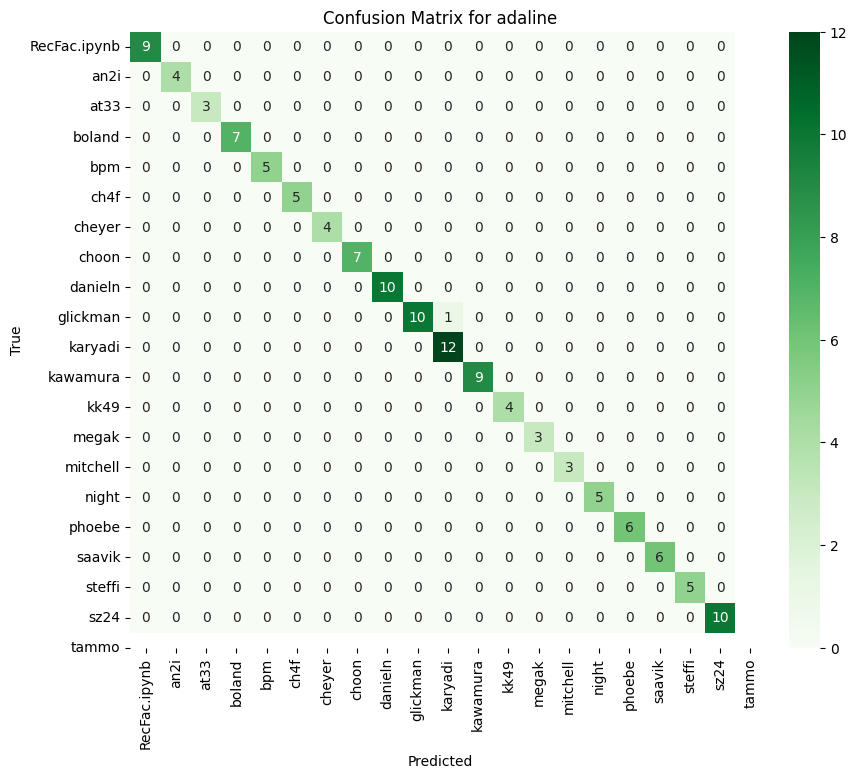

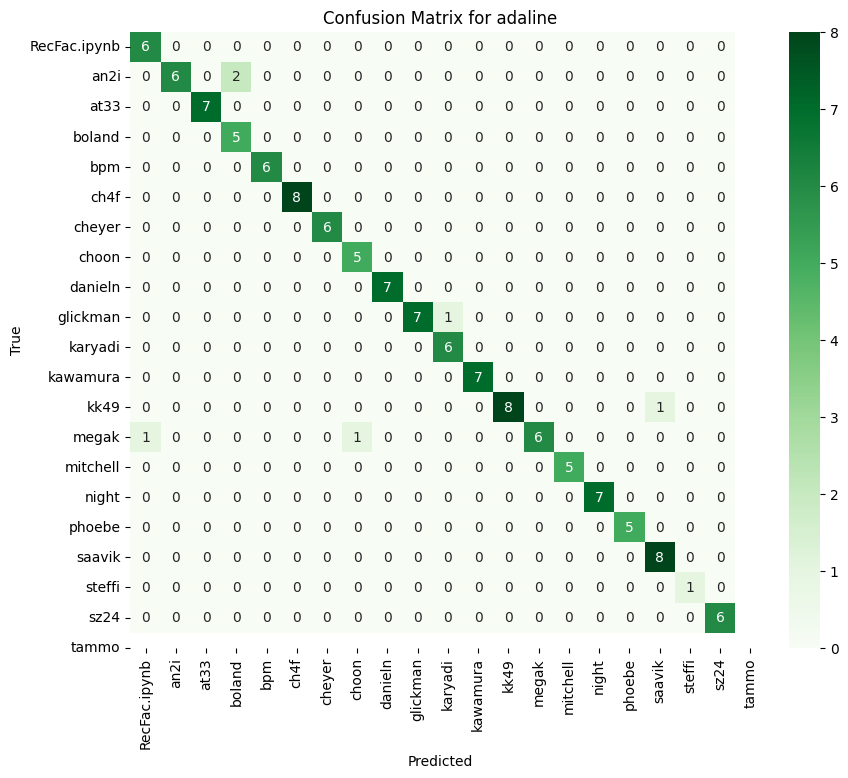

In [42]:
y_test_best_adaline = y_test_all_adaline[max_accuracy_idx_adaline]
y_pred_best_adaline = y_pred_all_adaline[max_accuracy_idx_adaline]
Y_best_true = np.argmax(y_test_best_adaline, axis=0)
plot_confusion_matrix(Y_best_true, y_pred_best_adaline, class_names, "adaline")

y_test_worst_adaline = y_test_all_adaline[min_accuracy_idx_adaline]
y_pred_worst_adaline = y_pred_all_adaline[min_accuracy_idx_adaline]
Y_worst_true = np.argmax(y_test_worst_adaline, axis=0)
plot_confusion_matrix(Y_worst_true, y_pred_worst_adaline, class_names, "adaline")


Para o MLP

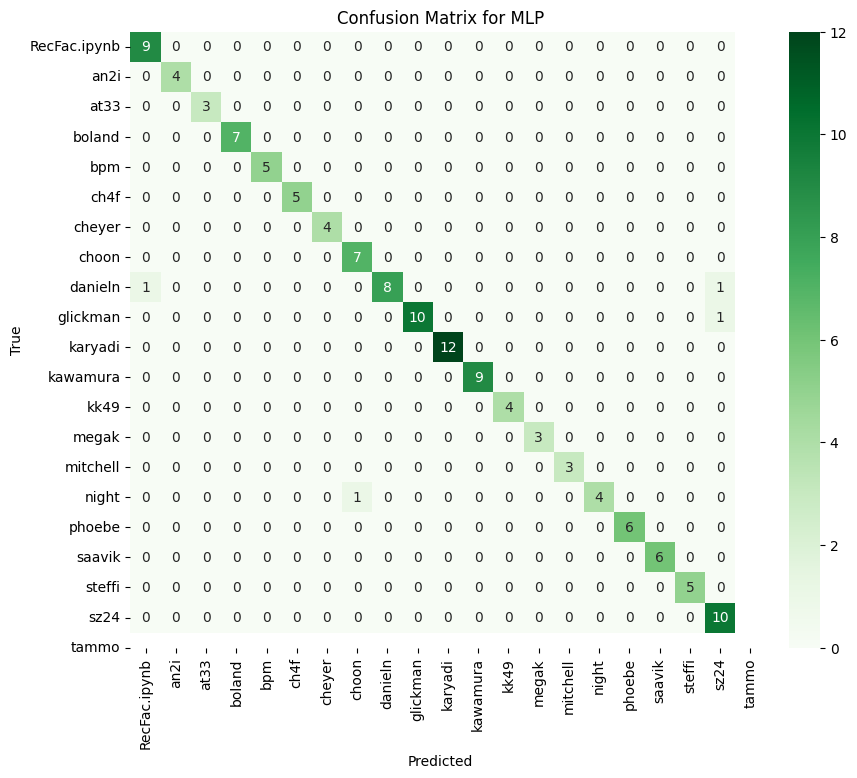

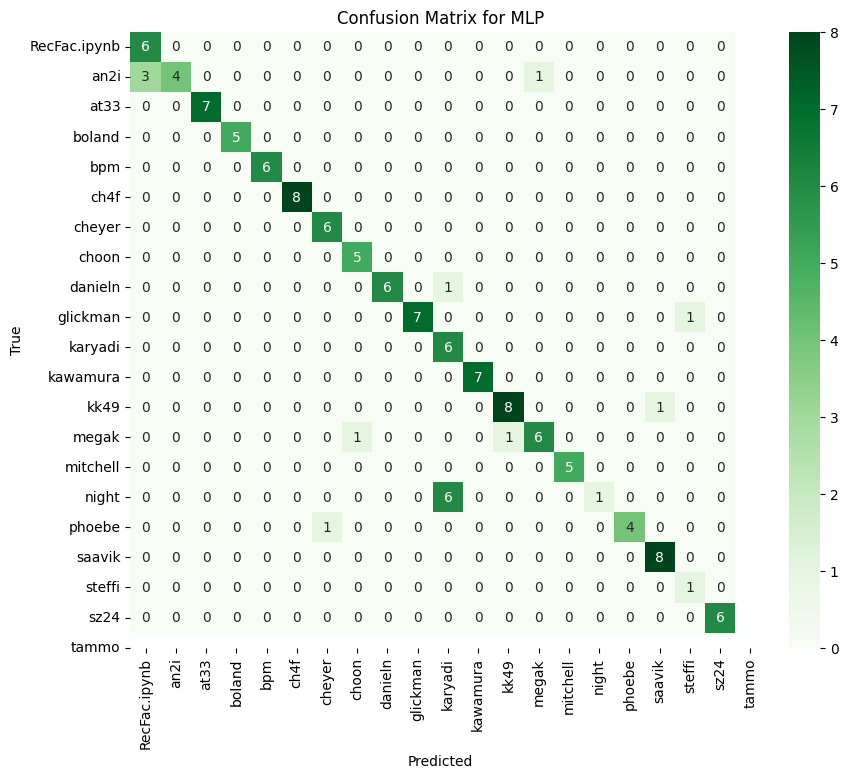

In [43]:
y_test_best_mlp = y_test_all_perceptron[max_accuracy_idx_mlp]
y_pred_best_mlp = y_pred_all_mlp[max_accuracy_idx_mlp]
Y_best_true = np.argmax(y_test_best_mlp, axis=0)
plot_confusion_matrix(Y_best_true, y_pred_best_mlp, class_names, "MLP")

y_test_worst_mlp = y_test_all_perceptron[min_accuracy_idx_mlp]
y_pred_worst_mlp = y_pred_all_mlp[min_accuracy_idx_mlp]
Y_worst_true = np.argmax(y_test_worst_mlp, axis=0)
plot_confusion_matrix(Y_worst_true, y_pred_worst_mlp, class_names, "MLP")


Melhor caso - Perceptron - Aprendizado

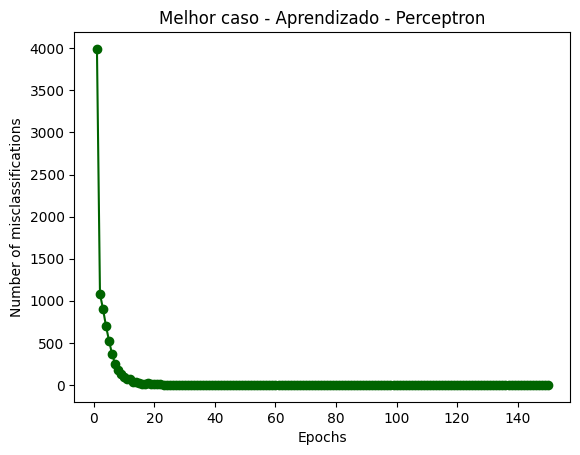

In [44]:
W_perceptron.train_perceptron(X_train_[max_accuracy_idx_perceptron], y_train_[max_accuracy_idx_perceptron])

plt.plot(range(1, len(W_perceptron.errors_) + 1), W_perceptron.errors_, marker = 'o', color='darkgreen')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
title = 'Melhor caso - Aprendizado - Perceptron'
plt.title(title)
# plt.savefig(path_to_save + ''.join(title.split(' ')) + '2')
plt.show()

Pior caso - Perceptron - Aprendizado

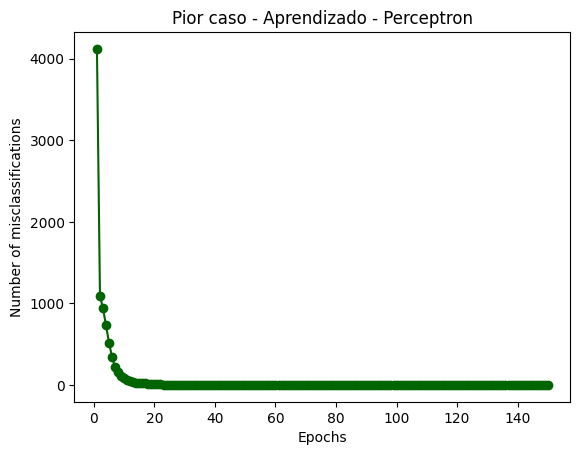

In [45]:
W_perceptron.train_perceptron(X_train_[min_accuracy_idx_perceptron], y_train_[min_accuracy_idx_perceptron])

plt.plot(range(1, len(W_perceptron.errors_) + 1), W_perceptron.errors_, marker = 'o', color='darkgreen')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
title = 'Pior caso - Aprendizado - Perceptron'
plt.title(title)
# plt.savefig(path_to_save + ''.join(title.split(' ')) + '2')
plt.show()

Melhor caso - Adaline - Aprendizado

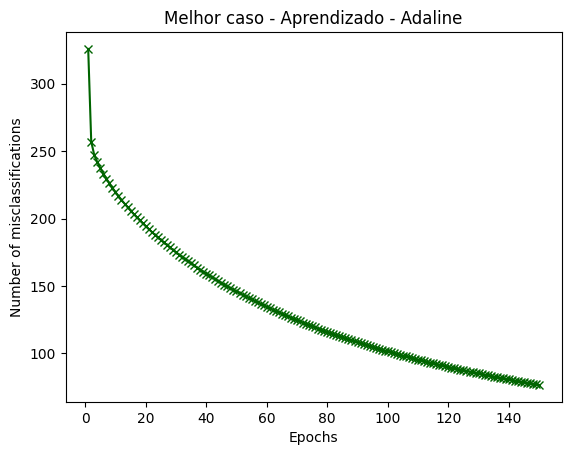

In [46]:
adaline.fit(X_train_[max_accuracy_idx_adaline], y_train_[max_accuracy_idx_adaline])

plt.plot(range(1, len(adaline.cost_) + 1), adaline.cost_, marker = 'x', color='darkgreen')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
title = 'Melhor caso - Aprendizado - Adaline'
plt.title(title)
# plt.savefig(path_to_save + ''.join(title.split(' ')) + '2')
plt.show()

Pior caso - Adaline - Aprendizado

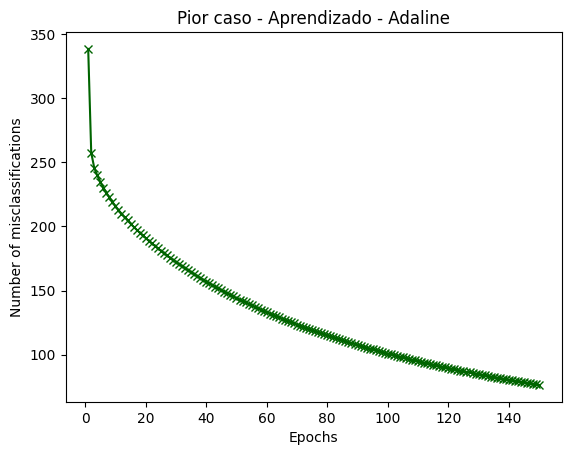

In [47]:
adaline.fit(X_train_[min_accuracy_idx_adaline], y_train_[min_accuracy_idx_adaline])

plt.plot(range(1, len(adaline.cost_) + 1), adaline.cost_, marker = 'x', color='darkgreen')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
title = 'Pior caso - Aprendizado - Adaline'
plt.title(title)
# plt.savefig(path_to_save + ''.join(title.split(' ')) + '2')
plt.show()

Melhor caso - MLP - Aprendizado

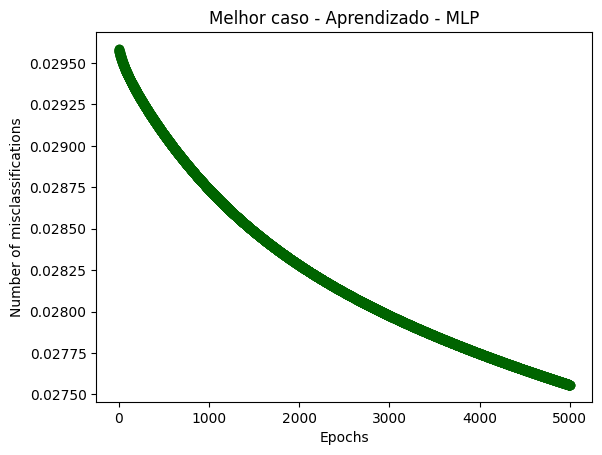

In [48]:
mlp.train(X_trainMLP_[max_accuracy_idx_mlp], y_trainMLP_[max_accuracy_idx_mlp], epochs=max_epochsmlp, tolerance=tolerance)

plt.plot(range(1, len(mlp.loss_history) + 1), mlp.loss_history, marker = 'o', color='darkgreen')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
title = 'Melhor caso - Aprendizado - MLP'
plt.title(title)
# plt.savefig(path_to_save + ''.join(title.split(' ')) + '2')
plt.show()

Pior caso - MLP - Aprendizado

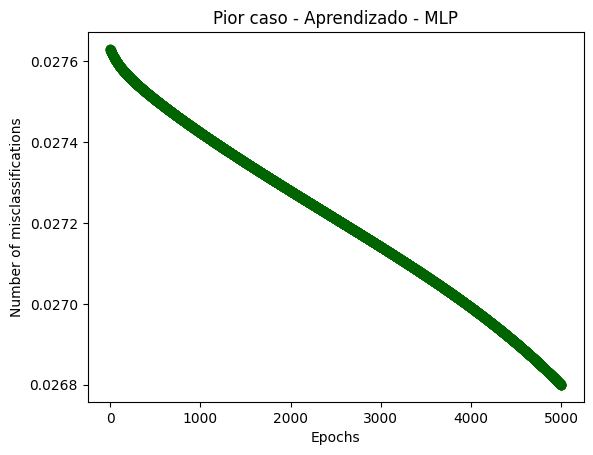

In [49]:
mlp.train(X_trainMLP_[min_accuracy_idx_mlp], y_trainMLP_[min_accuracy_idx_mlp], epochs=max_epochsmlp, tolerance=tolerance)

plt.plot(range(1, len(mlp.loss_history) + 1), mlp.loss_history, marker = 'o', color='darkgreen')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
title = 'Pior caso - Aprendizado - MLP'
plt.title(title)
# plt.savefig(path_to_save + ''.join(title.split(' ')) + '2')
plt.show()